In [25]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import subprocess
from tqdm.notebook import tqdm
import json

# Plot multiple runs of single experiment

In [2]:
n_blocks = 2
n_threads_per_block = 1024
n_runs = 100
n_warmup = 10
n_padding = 1
n_floats = 1

In [3]:
res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_padding, n_floats]]], capture_output=True, text=True)

In [7]:
times_contiguous, times_block_malloc, times_all_malloc, _ = [np.fromstring(x, sep=" ") for x in res.stdout.split("\n")[:4]]

ValueError: not enough values to unpack (expected 4, got 1)

In [8]:
plt.plot(list(range(len(times_contiguous))), times_contiguous, label="contiguous")
plt.plot(list(range(len(times_malloc))), times_malloc, label="malloc")
plt.legend()
plt.show()

NameError: name 'times_contiguous' is not defined

# Make plots

In [9]:
def get_mean_std(n_blocks, n_threads_per_block, n_floats, n_padding, n_runs=100, n_warmup=10, cache_warmup=1):
    cmd_res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_padding, n_floats, cache_warmup]]], capture_output=True, text=True)
    cmd_res.check_returncode()
    measurements = [np.fromstring(x, sep=" ") for x in cmd_res.stdout.split("\n")[:4]]
    res = []
    for m in measurements:
        res.append(np.mean(m))
        res.append(np.std(m))
  
    return res

In [42]:
plot_save_dir = "plots"

def plot_runtime_by_param(
    param_name,
    param_values,
    yscale="linear",
    contig=True,
    warp=True,
    block=True,
    all_malloc=True,
    save_results=True,
    **fix_params
):
    results = []
    for v in tqdm(param_values):
        results.append(get_mean_std(**{param_name: v}, **fix_params))
        
    means_contig, stds_contig, means_warp_malloc, stds_warp_malloc, means_block_malloc, stds_block_malloc, means_all_malloc, stds_all_malloc = zip(*results)
    
    if save_results:
        global_plot_id = max([int(x[:-5]) for x in os.listdir(plot_save_dir) if x[-5:] == ".json"] + [-1]) + 1
        result_dict = {
            "param_name": param_name,
            "param_values": param_values,
            "fix_params": fix_params,
            "means_contig": means_contig,
            "stds_contig": stds_contig,
            "means_warp_malloc": means_warp_malloc,
            "stds_warp_malloc": stds_warp_malloc,
            "mean_block_malloc": means_block_malloc,
            "stds_block_malloc": stds_block_malloc,
            "means_all_malloc": means_all_malloc,
            "stds_all_malloc": stds_all_malloc
        }
        with open(os.path.join(plot_save_dir, '{}.json'.format(global_plot_id)), 'w') as f:
            json.dump(result_dict, f)
    
    if contig:
        plt.errorbar(param_values, means_contig, stds_contig, label="contiguous")
    if warp:
        plt.errorbar(param_values, means_warp_malloc, stds_warp_malloc, label="warp malloc")
    if block:
        plt.errorbar(param_values, means_block_malloc, stds_block_malloc, label="block malloc")
    if all_malloc:
        plt.errorbar(param_values, means_all_malloc, stds_all_malloc, label="all malloc")
    
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel("# " + " ".join(param_name.split("_")[1:]))
    plt.ylabel("# clock cycles")
    
    print("Plot #{}".format(global_plot_id))
    plt.savefig(os.path.join(plot_save_dir, "{}.png".format(global_plot_id)))
    plt.show()



## Compare methods by number of floats

  0%|          | 0/3 [00:00<?, ?it/s]

Plot #0


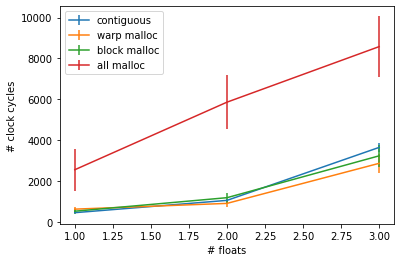

In [43]:
plot_runtime_by_param(
    param_name="n_floats",
    param_values=list(range(1, 4)),
    n_blocks=32,
    n_threads_per_block=1024,
    n_padding=0,
    cache_warmup=1
)

  0%|          | 0/14 [00:00<?, ?it/s]

Plot #1


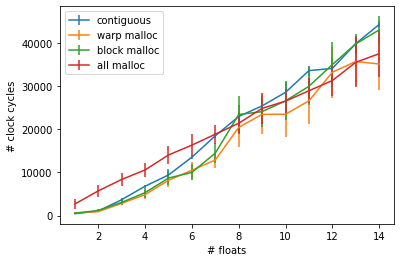

In [44]:
plot_runtime_by_param(
    param_name="n_floats",
    param_values=list(range(1, 15)),
    n_blocks=32,
    n_threads_per_block=1024,
    n_padding=0,
    cache_warmup=1
)

## Effect of stride

  0%|          | 0/3 [00:00<?, ?it/s]

Plot #2


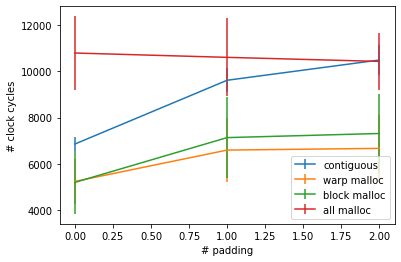

In [46]:
plot_runtime_by_param(
    param_name="n_padding",
    param_values=list(range(3)),
    n_floats=4,
    n_blocks=32,
    n_threads_per_block=1024,
    cache_warmup=1
)

  0%|          | 0/3 [00:00<?, ?it/s]

Plot #3


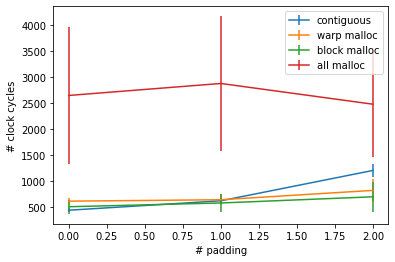

In [47]:
plot_runtime_by_param(
    param_name="n_padding",
    param_values=list(range(3)),
    n_floats=1,
    n_blocks=32,
    n_threads_per_block=1024,
    cache_warmup=1
)

  0%|          | 0/3 [00:00<?, ?it/s]

Plot #4


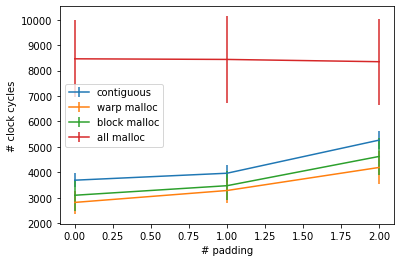

In [48]:
plot_runtime_by_param(
    param_name="n_padding",
    param_values=list(range(3)),
    n_floats=3,
    n_blocks=32,
    n_threads_per_block=1024,
    cache_warmup=1
)